In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torchvision import transforms

from utils.utils import load_config, create_folder, scale_coords
from utils.plots import *
from dataloaders import *
from models import *
from validate import *

from utils.plots import *



import pickle
import cv2

from insightface.app import FaceAnalysis
from tqdm import tqdm

from XAI import *

from tqdm import tqdm
import re
import gc

from torch.utils.data import DataLoader, TensorDataset

import matplotlib

import warnings
warnings.filterwarnings("ignore")

In [2]:
path_icopevid = 'Datasets\\Originais\\iCOPE\\iCOPEvid'
path_icopevid_frames = 'Datasets\\Originais\\iCOPE\\iCOPEvid\\all_frames'

# Face Detection


In [3]:
retinaface = FaceAnalysis(allowed_modules=['detection','landmark_2d_106'], providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
retinaface.prepare(ctx_id=0, det_size=(640, 640)) 

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'cudnn_conv1d_pad_to_nc1d': '0', 'has_user_compute_stream': '0', 'gpu_external_alloc': '0', 'enable_cuda_graph': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0'}, 'CPUExecutionProvider': {}}
model ignore: C:\Users\leonardo/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'cudnn_conv1d_pad_to_nc1d': '0', 'has_user_compute_stream': '0', 'g

In [4]:
for video_path in tqdm(os.listdir(path_icopevid)):
    if video_path.endswith('mp4'):
        video_name = video_path.split('.mp4')[0]

        if "Pain" in video_name or "Rest" in video_name:

            create_folder(os.path.join(path_icopevid_frames, video_name))

            video = cv2.VideoCapture(os.path.join(path_icopevid, video_path))

            idx = 0
            while True:
                ret, frame = video.read()

                if not ret:
                    break
                
                frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                try:
                    faces = retinaface.get(frame_rgb)[0]
                    bbox = faces['bbox'].astype('int')
                    bbox[bbox < 0] = 0
                    x1 = bbox[0]
                    y1 = bbox[1]
                    x2 = bbox[2]
                    y2 = bbox[3]

                    face = frame[y1:y2,x1:x2]
                    cv2.imwrite(os.path.join(path_icopevid_frames, 
                                            video_name, 
                                            video_name+"_"+f'{idx:04d}'+'.jpg'), face)
                    
                    landmarks = faces['landmark_2d_106'].astype('int')

                    scaled_landmarks = [scale_coords(x, y, bbox) for x, y in landmarks]


                    create_folder(os.path.join(path_icopevid_frames, 
                                            video_name,
                                            'landmarks'))

                    with open(os.path.join(path_icopevid_frames, 
                                            video_name, 
                                            'landmarks',
                                            video_name+"_"+f'{idx:04d}'+'.pkl'), 'wb') as f:
                        pickle.dump(scaled_landmarks, f)

                except IndexError:
                    cv2.imwrite(os.path.join(path_icopevid_frames, 
                                            video_name, 
                                            video_name+"_"+f'{idx:04d}'+'_blank'+'.jpg'), np.zeros((224,224,1)))
                    pass

                idx += 1
            video.release()

  1%|          | 1/175 [00:00<00:00, 995.09it/s]


FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: 'Datasets\\Originais\\iCOPE\\iCOPEvid\\all_frames\\S001_Pain_1_[0]_20s'

# Audio Extraction

In [ ]:
from moviepy.editor import VideoFileClip
import numpy as np

In [ ]:
for video_path in tqdm(os.listdir(path_icopevid)):
    if video_path.endswith('mp4'):
        video_name = video_path.split('.mp4')[0]

        if "Pain" in video_name or "Rest" in video_name:

            # Load the video using MoviePy
            video_clip = VideoFileClip(os.path.join(path_icopevid, video_path), audio_fps=48000)

            # Extract audio from the video
            audio_signal = video_clip.audio

            # Convert audio signal to a numpy array
            audio_array = np.array(audio_signal.to_soundarray())

            with open(os.path.join(path_icopevid_frames,video_name,f'audio_signal.pkl'), 'wb') as f:
                pickle.dump(audio_array, f)

            # Close the video clip
            video_clip.close()


# Creating the predictions dataframe

In [3]:
model_name = "ViTNB_test"

#path_experiments = "experiments\\DEPLOY_MODELS\\" + model_name

best = '\\20241029_1312_ViTNB'

path_experiments = 'experiments\\UNIFESP+iCOPE\\' + model_name + best

device = "cuda"

## All folds - Predictions with MCDP

In [15]:
from uncertainty.MCDropout import MCDropout
from dataloaders import iCOPEVidDataset

In [23]:
p = 0.0
reps = 1

In [28]:
results_video = dict()
for video_path in tqdm(os.listdir(path_icopevid_frames)):
    if not video_path.endswith('.pkl'):
        
        results_folds = dict()
        # Para cada video iremos rodar os modelos de cada fold e salvar os resultados
        for exp in os.listdir(path_experiments):  
            if not exp.endswith('.pkl'):
                if exp == best:          
                    # Carregar modelo e config.yaml
                    path_model = os.path.join(path_experiments, exp, 'Model','best_model.pt')
                    path_yaml = os.path.join(path_experiments, exp, 'Model','config.yaml')

                    # Carrego o .yaml para pegar o path do test, ou seja, o fold que foi utilizado
                    config = load_config(path_yaml)
                    test_path = config['path_test']
                    fold = test_path.split('\\')[-2]
                    
                    # Carrego o .yaml para pegar o path do test, ou seja, o fold que foi utilizado
                    if "NCNN" in exp:
                        model = NCNN().to(device)
                    elif "VGGNB" in exp:
                        model = VGGNB().to(device)
                    elif "ViTNB" in exp:
                        model = ViTNB().to(device)
                    
                    # Carrego o modelo
                    model.eval()
                    model.load_state_dict(torch.load(path_model))
                    model = model.to(device)
                    #model = MCDropout(model, p=p)
                    
                    # Iteração sobre os dados salvando os probs, preds e labels
                    probs_list = torch.empty(0, device=device)

                    dataset = iCOPEVidDataset(os.path.join(path_icopevid_frames,video_path), model_name)
                    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

                    with torch.no_grad():
                        for batch in dataloader:
                            img_batch, blanks, _ = batch

                            #probs = model.predict(img_batch.to(device), reps)
                            probs = model.predict(img_batch.to(device))

                            probs[blanks] = np.nan

                            probs_list = torch.cat([probs_list, probs])

                    gc.collect()
                    torch.cuda.empty_cache()
                                
                    results_folds[fold] = probs_list.cpu().numpy()

            gc.collect()
            torch.cuda.empty_cache()
                    
            results_video[video_path] = results_folds

with open(os.path.join(path_icopevid_frames,f'results_{model_name}_test.pkl'), 'wb') as f:
    pickle.dump(results_video, f) 

100%|██████████| 125/125 [15:21<00:00,  7.37s/it]


### Create XAIs

In [7]:
 #Carregar modelo e config.yaml
path_model = os.path.join(path_experiments, 'Model','best_model.pt')
path_yaml = os.path.join(path_experiments, 'Model','config.yaml')

# Carrego o .yaml para pegar o path do test, ou seja, o fold que foi utilizado
config = load_config(path_yaml)
test_path = config['path_test']
fold = test_path.split('\\')[-2]

# Carrego o .yaml para pegar o path do test, ou seja, o fold que foi utilizado
if "NCNN" in path_experiments:
    model = NCNN().to(device)
    
    ig = IntegratedGradients(model, device=device)
    gradcam = GradCAM(model, model.conv_4, device=device)

elif "VGGNB" in path_experiments:
    model = VGGNB().to(device)

    ig = IntegratedGradients(model, device=device)
    gradcam = GradCAM(model, model.VGGFace.features.conv5_3, device=device)

elif "ViTNB" in path_experiments:
    model = ViTNB().to(device)

    ig = IntegratedGradients(model, device=device)
    gradcam = GradCAM(model, model.ViT.encoder.layers.encoder_layer_11.ln_1, device=device, reshape_transform_ViT=True)

# Carrego o modelo
model.eval()
model.load_state_dict(torch.load(path_model))
model = model.to(device)

results_video = dict()

BATCH_SIZE = 32  # Adjust based on GPU memory

for video_path in tqdm(os.listdir(path_icopevid_frames)):
    if not video_path.endswith('.pkl'):

        # Create output folders for GradCAM and Integrated Gradients results.
        gc_folder = os.path.join(path_icopevid_frames, video_path, f"GC_{model_name}")
        ig_folder = os.path.join(path_icopevid_frames, video_path, f"IG_{model_name}")
        create_folder(gc_folder)
        create_folder(ig_folder)

        dataset = iCOPEVidDataset(os.path.join(path_icopevid_frames,video_path), model_name)

        # Collect images and corresponding file names in batches.
        batch_imgs  = []
        batch_files = []
        for img, blank, file_name in dataset:
            if blank:
                continue

            batch_imgs.append(img)
            batch_files.append(file_name)

            if len(batch_imgs) == BATCH_SIZE:
                # Stack into a batch tensor of shape (B, C, H, W)
                batch_tensor = torch.stack(batch_imgs, dim=0).to(device)
                # Compute attribution masks in batch.
                masks_ig = ig.attribution_mask(batch_tensor)
                masks_gc = gradcam.attribution_mask(batch_tensor)

                # Save each image’s masks.
                for i, f_name in enumerate(batch_files):
                    name = f_name.replace(".jpg", ".pkl")
                    with open(os.path.join(gc_folder, name), 'wb') as f:
                        pickle.dump(masks_gc[i], f)
                    with open(os.path.join(ig_folder, name), 'wb') as f:
                        pickle.dump(masks_ig[i], f)
                # Clear the batch.
                batch_imgs  = []
                batch_files = []

        # Process any remaining images in the last (incomplete) batch.
        if len(batch_imgs) > 0:
            batch_tensor = torch.stack(batch_imgs, dim=0).to(device)
            masks_ig = ig.attribution_mask(batch_tensor)
            masks_gc = gradcam.attribution_mask(batch_tensor)
            for i, f_name in enumerate(batch_files):
                name = f_name.replace(".jpg", ".pkl")
                with open(os.path.join(gc_folder, name), 'wb') as f:
                    pickle.dump(masks_gc[i], f)
                with open(os.path.join(ig_folder, name), 'wb') as f:
                    pickle.dump(masks_ig[i], f)

        # Cleanup after processing this experiment.
        del dataset, batch_imgs, batch_files
        gc.collect()
        torch.cuda.empty_cache()

100%|██████████| 126/126 [34:14<00:00, 16.30s/it]


### Create XAi visualization

In [8]:
def create_xais(images_dir, model):

    if "VGGNB" in model or "ViTNB" in model:
        size = (224,224)
    else:
        size = (120,120)

    plt.figure(figsize=(8,8))
    for file_name in os.listdir(images_dir):
        if "blank" not in file_name and (file_name.endswith('.png') or file_name.endswith('.jpg')):
            file_path = os.path.join(images_dir, file_name)
            img = cv2.cvtColor(cv2.resize(cv2.imread(file_path), size), cv2.COLOR_BGR2RGB)

            file_path_gc = os.path.join(images_dir, f"GC_{model}", file_name.replace('.jpg', '.pkl'))
            file_path_ig = os.path.join(images_dir, f"IG_{model}", file_name.replace('.jpg', '.pkl'))

            with open(file_path_gc, 'rb') as f:
                mask_gc = pickle.load(f)

            with open(file_path_ig, 'rb') as f:
                mask_ig = pickle.load(f)

            mask_gc, alpha_gc = attribution_mask_processing(mask_gc)
            mask_ig, alpha_ig = attribution_mask_processing(mask_ig)
        
            # Define the plot colors
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

            # Plot
            plt.imshow(img)
            plt.imshow(mask_gc, cmap=cmap, alpha=alpha_gc)
            plt.axis('off')
            plt.savefig(os.path.join(images_dir, f"GC_{model}", file_name), dpi=50, bbox_inches='tight', pad_inches=0)
            plt.clf()
            plt.cla()

            plt.imshow(img)
            plt.imshow(mask_ig, cmap=cmap, alpha=alpha_ig)
            plt.axis('off')
            plt.savefig(os.path.join(images_dir, f"IG_{model}", file_name), dpi=50, bbox_inches='tight', pad_inches=0)
            plt.clf()
            plt.cla()

    plt.close('all')
    gc.collect()

 10%|▉         | 12/126 [16:29<2:36:38, 82.45s/it] 


KeyboardInterrupt: 

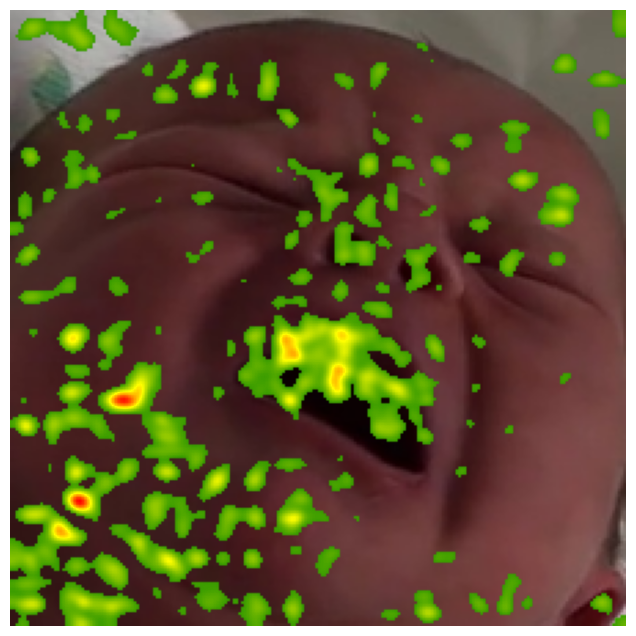

In [9]:
for video_path in tqdm(os.listdir(path_icopevid_frames)):
    if not video_path.endswith('.pkl'):
        create_xais(os.path.join(path_icopevid_frames,video_path), model_name)

# Pain Signal Visualization

In [3]:
from validate import validation_metrics
from scipy import stats
import matplotlib
import glob
from scipy.stats import entropy
from scipy import integrate
from scipy.signal import butter, lfilter, freqz, filtfilt

In [4]:

def butter_lowpass_filter(data, cutoff=2, fs=30, order=2):
    normal_cutoff = cutoff / (0.5 * fs)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def get_hist(signal):
    return np.histogram(signal, bins=np.linspace(0.0, 1.0, 11))

def get_probs(signal):
    hist, _ = get_hist(signal)
    return hist / len(signal)

def get_entropy(signal):
    pk = get_probs(signal)
    return entropy(pk, base=2)

def get_entropy_curve(signal):
    hist, bin_edges = get_hist(signal)
    pk = hist / len(signal)
    entropies = []
    for x in signal:
        idx = np.digitize(x, bin_edges, right=True)
        pkx = pk[idx-1]
        entropies.append(-((pkx * np.log(pkx)) / np.log(2)))
    return entropies

def get_auc(signal):
    return integrate.trapezoid(signal) / len(signal)

def get_auc_curve(signal):
    window_size = 10
    step = 1
    auc_curve = []
    for x in range(0, len(signal)-window_size, step):
        window = signal[x:x+window_size]
        auc_curve.append(get_auc(window))
    return auc_curve

def interp_curve(signal):
    time = np.linspace(0,len(signal),len(signal))
    # Find indices of missing values
    missing_indices = np.isnan(signal)
    # Find indices of non-missing values
    valid_indices = ~missing_indices
    # Perform linear interpolation
    interpolated_values = np.interp(time[missing_indices], time[valid_indices], signal[valid_indices])
    # Replace missing values with interpolated values
    signal[missing_indices] = interpolated_values

    return signal

def fill_nan(signal):
    # Find indices of missing values
    missing_indices = np.isnan(signal)
    # Find indices of non-missing values
    valid_indices = ~missing_indices
    # Perform linear interpolation
    mean = np.mean(signal[valid_indices])
    # Replace missing values with interpolated values
    signal[missing_indices] = mean

    return signal


def peak_to_peak(signal):
    return (np.abs(np.max(signal)) - np.abs(np.min(signal)))

def derivative(signal, power=False):
    if power:
        return np.power(np.diff(signal),2)
    else:
        return np.diff(signal)
    
def RMS(signal):
    return np.sqrt(np.mean(np.square(signal)))

def thresh_crossing(signal, thresh=0.5):
    return len(np.where(np.diff(np.sign(signal-thresh)))[0]) 

In [5]:
model = "VGGNB_MCDP"
model_name = "VGG-Face"

In [6]:
with open(os.path.join(path_icopevid_frames,f'results_{model}.pkl'), 'rb') as f:
    results_video = pickle.load(f)

In [7]:
mcdp = True

## MCDP predictions

In [13]:
labels = []
preds = []
probs = []

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])
plt.style.use('utils\plotstyle.mplstyle')

if "NCNN" in model:
    theta_1 = 0.542
    theta_3 = 0.047
    lower_tresh = 0.1
    upper_tresh = 0.8
elif "VGGNB" in model:
    theta_1 = 0.494
    theta_3 = 0.0447
    lower_tresh = 0.2
    upper_tresh = 0.8
else:
    theta_1 = 0.431


for video in tqdm(results_video.keys()):

    full_frames_path = os.path.join(path_icopevid_frames,video)
    img_files = os.listdir(full_frames_path)[5:] # MELHORAR ISSO, USEI PARA FICAR IGUAL AO PAPER
    frame_seq = []

    gc_frame_seq = []
    gc_alpha_seq = []

    ig_frame_seq = []
    ig_alpha_seq= []

    ar_frame_seq = []
    ar_alpha_seq= []

    for i in range(0, len(img_files), 30):
        if img_files[i].endswith('.jpg'):
            img = cv2.imread(os.path.join(full_frames_path, img_files[i]))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (256,256))
            frame_seq.append(img/255)

            try:
                mask_gc = cv2.imread(os.path.join(full_frames_path,f"GC_{model}", img_files[i]))
                mask_gc = cv2.cvtColor(mask_gc, cv2.COLOR_BGR2RGB)
                mask_gc = cv2.resize(mask_gc, (256,256))
            except:
                mask_gc = np.zeros((256,256,3))

            try:    
                mask_ig = cv2.imread(os.path.join(full_frames_path,f"IG_{model}", img_files[i]))
                mask_ig = cv2.cvtColor(mask_ig, cv2.COLOR_BGR2RGB)
                mask_ig = cv2.resize(mask_ig, (256,256))
            except:
                mask_ig = np.zeros((256,256,3))

            gc_frame_seq.append(mask_gc/255)
            ig_frame_seq.append(mask_ig/255)

    frame_seq = np.hstack(frame_seq)


    gc_seq = np.hstack(gc_frame_seq)
    ig_seq = np.hstack(ig_frame_seq)

    frame_seq = np.vstack((frame_seq, gc_seq, ig_seq))
   
    if "Pain" in video:
        labels.append(1)
    else:
        labels.append(0)

    if mcdp:
        mean_probs = []
        std_probs = []
        for fold in list(results_video[video].keys()):
            for array in results_video[video][fold]:
                array = np.asarray(array)
                if not np.isnan(array).any():
                    mean_probs.append(array.mean())
                    std_probs.append(array.std())
                else:
                    mean_probs.append(np.nan)
                    std_probs.append(np.nan)

        mean_probs = interp_curve(np.asarray(mean_probs))
        std_probs = interp_curve(np.asarray(std_probs))
        
        ma_window = 30
        ma_probs = moving_average(mean_probs, ma_window)
        std_ma_probs = moving_average(std_probs, ma_window)
    
    else:
        stacked_probs = []
        for fold in list(results_video[video].keys()):
            if "NCNN" in model and fold == "9":
                stacked_probs.append(interp_curve(results_video[video][fold]))
            elif "VGGNB" in model and fold == "7":
                stacked_probs.append(interp_curve(results_video[video][fold]))
            elif "ViTNB" in model and fold == "8":
                stacked_probs.append(interp_curve(results_video[video][fold]))

        stacked_probs = np.array(stacked_probs)
        mean_probs = stacked_probs.mean(axis=0)
        
        ma_window = 30
        ma_probs = moving_average(mean_probs, ma_window)
        
    preds.append((ma_probs.mean() >= theta_1).astype('int'))
    probs.append(ma_probs.mean())

    time = np.linspace(0,20,len(ma_probs))

    #idx_precise = (ma_probs <= lower_tresh) & (ma_probs >= upper_tresh)
    #idx_certain = std_ma_probs <= theta_3

    #ma_probs_precision = ma_probs[idx_precision]
    #std_ma_precision = std_ma_probs[idx_precision]
    #time_precision = time[idx_precision]

    #ma_probs_imprecision = ma_probs[~idx_precision]
    #std_ma_imprecision = std_ma_probs[~idx_precision]
    #time_imprecision = time[~idx_precision]

    #ma_probs_precision = np.ma.masked_where(std_ma_probs > theta_3, ma_probs) # é ao contratrio essa função
    #ma_probs_imprecision = np.ma.masked_where(std_ma_probs <= theta_3, ma_probs)

    #std_ma_precision = np.ma.masked_where(std_ma_probs > theta_3, std_ma_probs) # é ao contratrio essa função
    #std_ma_imprecision = np.ma.masked_where(std_ma_probs <= theta_3, std_ma_probs)

    idx = np.where(np.diff(np.sign(ma_probs-theta_1)))[0]
   
    plt.figure(figsize=(15,6))

    plt.subplot(2,1,1)

    plt.plot(time, ma_probs, 'k')
    #plt.plot(time, ma_probs_precision, 'k', time, ma_probs_imprecision, 'r')
    #plt.plot(time_audio, (audio_signal*0.8)+0.5, 'b', alpha=0.2)
    #plt.fill_between(x=time, y1=ma_probs+std_ma_probs, y2=ma_probs-std_ma_probs, alpha=0.2, color="#000000", edgecolor="none")
    #plt.fill_between(x=time, y1=ma_probs_precision+std_ma_precision, y2=ma_probs_precision-std_ma_precision, alpha=0.2, color="#000000", edgecolor="none")
    #plt.fill_between(x=time, y1=ma_probs_imprecision+std_ma_imprecision, y2=ma_probs_imprecision-std_ma_imprecision, alpha=0.2, color="red", edgecolor="none")

    plt.ylim([-0.05,1.05])
    plt.xlim([-0.05,20])

    label = "Pain" if "Pain" in video else "No Pain"

    temp_1 = "Pain" if ma_probs.mean() >= theta_1 else "No Pain"

    #temp_3 = "Certo" if std_ma_probs.mean() <= theta_3 else "Incerto"

    #plt.title(f"Classe real = {label} / $\\hat{{p}}$ = {ma_probs.mean():.4f} $\\rightarrow$ {temp_1} / $\\hat{{\\sigma}}$ = {std_ma_probs.mean():.4f} $\\rightarrow$ {temp_3} / $H$ = {get_entropy(ma_probs):.4f} / Pontos de Inflexão =  {thresh_crossing(ma_probs, theta_1)}", fontsize=20)
    plt.title(f"Model = {model_name} / Label = {label} / $\\hat{{p}}$ = {ma_probs.mean():.2f} $\\rightarrow$ {temp_1} / Entropy = {get_entropy(ma_probs):.2f} / Crossings = {thresh_crossing(ma_probs, theta_1)}") #, fontsize=20
    plt.ylabel("Pain Probability")
    plt.xlabel("Time [s]")

    plt.plot(time[idx],[theta_1]*len(idx), 'ro')

    plt.hlines(y=theta_1, xmin=0,xmax=20, linestyle=":", color='#9e9e9e')
    #plt.text(20.1, theta_1, "$\\theta_{{1}}$", fontsize=20)

    #plt.hlines(y=lower_tresh, xmin=0,xmax=20, linestyle=":", color='#9e9e9e')
    #plt.text(20.1, lower_tresh, "$\\theta_{{2}}$", fontsize=20)

    #plt.hlines(y=upper_tresh, xmin=0,xmax=20, linestyle=":", color='#9e9e9e')
    #plt.text(20.1, upper_tresh, "$\\theta_{{2}}$", fontsize=20)

    #plt.text(0.5, 0.8, f"$\\hat{{p}}$ = {ma_probs.mean():.4f}\n"+
                       #f"$\\hat{{\\sigma}}$ = {std_ma_probs.mean():.4f}\n"+
                       #f"$H$ = {get_entropy(ma_probs):.4f}\n"+
                       #f"Pontos de Inflexão =  {thresh_crossing(ma_probs, theta_1)}")

    #plt.legend(loc='upper right')

    #plt.subplot(5,1,2)
    #entropies = get_entropy_curve(ma_probs)
    #plt.plot(entropies, label=f'Entropy: {get_entropy(ma_probs):.4f}', color="#000000")
    #plt.legend(loc='upper right')
    #plt.xlim([-0.05,600])
    #plt.ylim([-0.05,1.05])

    #plt.subplot(6,1,3)
    #auc_curve = get_auc_curve(ma_probs)
    #plt.plot(auc_curve, label=f'AUC: {get_auc(ma_probs):.4f}', color="#000000")
    #plt.legend(loc='upper right')
    #plt.xlim([-0.05,600])
    #plt.ylim([-0.05,1.05])

    plt.subplot(2,1,2)
    plt.imshow(frame_seq)
    plt.axis('off')

    plt.text(-50, 125, 'Frames', horizontalalignment='center', verticalalignment='center', rotation=90)
    plt.text(-50, 375, 'GC', horizontalalignment='center', verticalalignment='center', rotation=90)
    plt.text(-50, 625, 'IG', horizontalalignment='center', verticalalignment='center', rotation=90)


    #plt.subplot(3,1,3)
    #plt.specgram(audio_signal, Fs=48000, NFFT=512, cmap='jet')

    #plt.subplot(4,1,3)
    #plt.imshow(frame_seq)
    #plt.imshow(gc_seq, cmap=cmap, alpha=gc_alpha_seq)
    #plt.axis('off')

    #plt.subplot(4,1,4)
    #plt.imshow(frame_seq)
    #plt.imshow(ig_seq, cmap=cmap, alpha=ig_alpha_seq)
    #plt.axis('off')

    #plt.show()
    plt.savefig(os.path.join("C:\\Users\\leonardo\\Desktop\\icopevid_results", f'{video}_{model}.pdf'), dpi=300, bbox_inches='tight')
    plt.close()

gc.collect()


print(validation_metrics(np.array(preds), np.array(probs), np.array(labels)))

100%|██████████| 120/120 [03:16<00:00,  1.64s/it]


{'Accuracy': 0.5916666666666667, 'F1 Score': 0.6141732283464567, 'Precision': 0.5, 'Sensitivity': 0.7959183673469388, 'Specificity': 0.4507042253521127, 'AUC': 0.688128772635815}


## TEST ALL PLOTS

KeyboardInterrupt: 

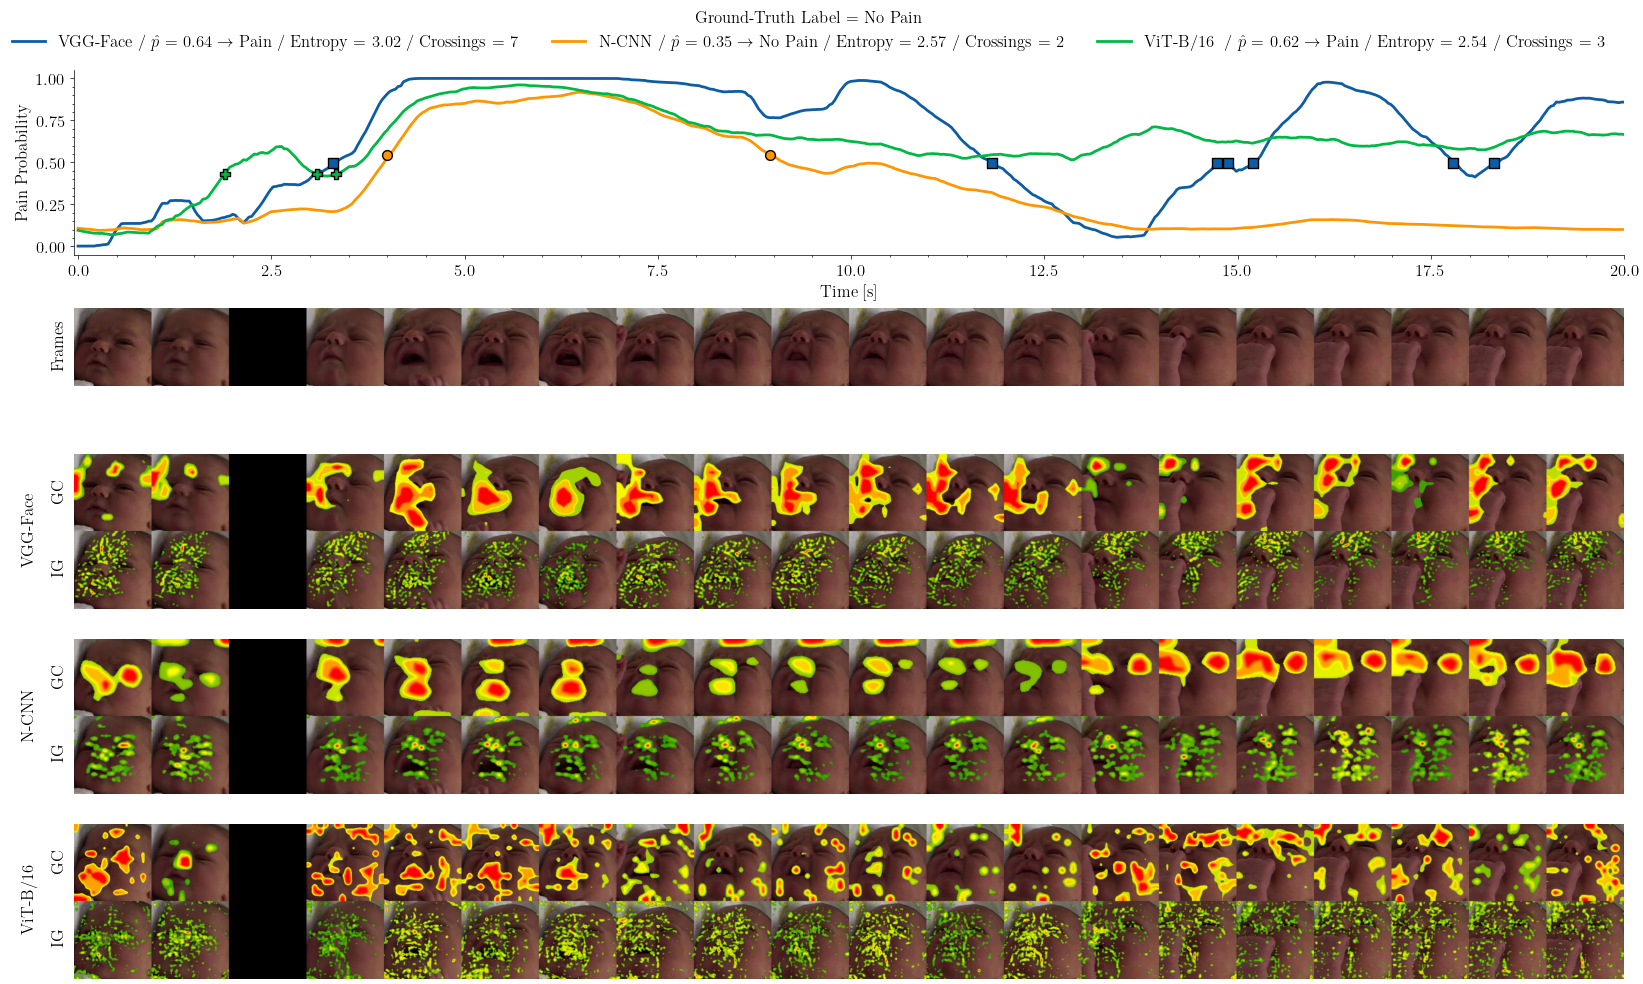

In [81]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])
plt.style.use('utils\plotstyle.mplstyle')

def stack_XAI(img_files, model):
    gc_frame_seq = []
    ig_frame_seq = []

    for i in range(0, len(img_files), 30):
        if img_files[i].endswith('.jpg'):

            try:
                mask_gc = cv2.imread(os.path.join(full_frames_path,f"GC_{model}", img_files[i]))
                mask_gc = cv2.cvtColor(mask_gc, cv2.COLOR_BGR2RGB)
                mask_gc = cv2.resize(mask_gc, (256,256))
            except:
                mask_gc = np.zeros((256,256,3))

            try:    
                mask_ig = cv2.imread(os.path.join(full_frames_path,f"IG_{model}", img_files[i]))
                mask_ig = cv2.cvtColor(mask_ig, cv2.COLOR_BGR2RGB)
                mask_ig = cv2.resize(mask_ig, (256,256))
            except:
                mask_ig = np.zeros((256,256,3))

            gc_frame_seq.append(mask_gc/255)
            ig_frame_seq.append(mask_ig/255)

    gc_seq = np.hstack(gc_frame_seq)
    ig_seq = np.hstack(ig_frame_seq)

    return np.vstack((gc_seq, ig_seq))

with open(os.path.join(path_icopevid_frames,f'results_NCNN_test.pkl'), 'rb') as f:
    results_video_NCNN = pickle.load(f)

with open(os.path.join(path_icopevid_frames,f'results_VGGNB_test.pkl'), 'rb') as f:
    results_video_VGGNB = pickle.load(f)

with open(os.path.join(path_icopevid_frames,f'results_ViTNB_test.pkl'), 'rb') as f:
    results_video_ViTNB = pickle.load(f)

for video in results_video_NCNN.keys():

    full_frames_path = os.path.join(path_icopevid_frames,video)
    img_files = os.listdir(full_frames_path)[5:] # MELHORAR ISSO, USEI PARA FICAR IGUAL AO PAPER
    frame_seq = []

    for i in range(0, len(img_files), 30):
        if img_files[i].endswith('.jpg'):
            img = cv2.imread(os.path.join(full_frames_path, img_files[i]))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (256,256))
            frame_seq.append(img/255)

    frame_seq = np.hstack(frame_seq)
   
    VGGNB_stack_xai = stack_XAI(img_files, 'VGGNB_test')
    NCNN_stack_xai = stack_XAI(img_files,'NCNN_test')
    ViTNB_stack_xai = stack_XAI(img_files,'ViTNB_test')

    plt.figure(figsize=(20,12))
    plt.subplot(5,1,1)

    for results_video ,name in zip([results_video_VGGNB, results_video_NCNN, results_video_ViTNB],['VGG-Face', 'N-CNN', "ViT-B/16"]):

        stacked_probs = []
        for fold in list(results_video[video].keys()):
            if "N-CNN" in name and fold == "9":
                stacked_probs.append(interp_curve(results_video[video][fold]))
            elif "VGG" in name and fold == "7":
                stacked_probs.append(interp_curve(results_video[video][fold]))
            elif "ViT" in name and fold == "8":
                stacked_probs.append(interp_curve(results_video[video][fold]))

        stacked_probs = np.array(stacked_probs)
        mean_probs = stacked_probs.mean(axis=0)
        
        ma_window = 30
        ma_probs = moving_average(mean_probs, ma_window)

        time = np.linspace(0,20,len(ma_probs))

        

        if "N-CNN" in name:
            theta_1 = 0.542
            color = '#FF9500'
            marker = 'o'
            temp_1 = "Pain" if ma_probs.mean() >= theta_1 else "No Pain"
            legenda = f"{name} / $\\hat{{p}}$ = {ma_probs.mean():.2f} $\\rightarrow$ {temp_1} / Entropy = {get_entropy(ma_probs):.2f} / Crossings = {thresh_crossing(ma_probs, theta_1)}"
        elif "VGG" in name:
            theta_1 = 0.494
            color = '#0C5DA5'
            marker = 's'
            temp_1 = "Pain" if ma_probs.mean() >= theta_1 else "No Pain"
            legenda = f"{name} / $\\hat{{p}}$ = {ma_probs.mean():.2f} $\\rightarrow$ {temp_1} / Entropy = {get_entropy(ma_probs):.2f} / Crossings = {thresh_crossing(ma_probs, theta_1)}"
        else:
            theta_1 = 0.431
            color = '#00B945'
            marker = 'P'
            temp_1 = "Pain" if ma_probs.mean() >= theta_1 else "No Pain"
            legenda = f"{name} $\\text{{}}$ / $\\hat{{p}}$ = {ma_probs.mean():.2f} $\\rightarrow$ {temp_1} / Entropy = {get_entropy(ma_probs):.2f} / Crossings = {thresh_crossing(ma_probs, theta_1)}"
        
        plt.plot(time, ma_probs, label=legenda, linewidth=2)

        idx = np.where(np.diff(np.sign(ma_probs-theta_1)))[0]
        plt.scatter(time[idx],[theta_1]*len(idx), color=color, marker=marker, edgecolor='k', s=50, zorder=10, clip_on=False)

    plt.ylim([-0.05,1.05])
    plt.xlim([-0.05,20])

    label = "Pain" if "Pain" in video else "No Pain"

    plt.ylabel("Pain Probability")
    plt.xlabel("Time [s]")


    #plt.hlines(y=0.5, xmin=0,xmax=20, linestyle=":", color='#9e9e9e')

    plt.legend(title=f"Ground-Truth Label = {label}", loc='upper left', bbox_to_anchor=(-0.05, 1.4), frameon=False, ncol=3)
    
    plt.subplot(5,1,2)
    plt.imshow(frame_seq)
    plt.axis('off')
    plt.text(-50, 125, 'Frames', horizontalalignment='center', verticalalignment='center', rotation=90)

    plt.subplot(5,1,3)
    plt.imshow(VGGNB_stack_xai)
    plt.axis('off')
    plt.text(-150, 250, 'VGG-Face', horizontalalignment='center', verticalalignment='center', rotation=90)
    plt.text(-50, 125, 'GC', horizontalalignment='center', verticalalignment='center', rotation=90)
    plt.text(-50, 375, 'IG', horizontalalignment='center', verticalalignment='center', rotation=90)

    plt.subplot(5,1,4)
    plt.imshow(NCNN_stack_xai)
    plt.axis('off')
    plt.text(-150, 250, 'N-CNN', horizontalalignment='center', verticalalignment='center', rotation=90)
    plt.text(-50, 125, 'GC', horizontalalignment='center', verticalalignment='center', rotation=90)
    plt.text(-50, 375, 'IG', horizontalalignment='center', verticalalignment='center', rotation=90)

    plt.subplot(5,1,5)
    plt.imshow(ViTNB_stack_xai)
    plt.axis('off')
    plt.text(-150, 250, 'ViT-B/16', horizontalalignment='center', verticalalignment='center', rotation=90)
    plt.text(-50, 125, 'GC', horizontalalignment='center', verticalalignment='center', rotation=90)
    plt.text(-50, 375, 'IG', horizontalalignment='center', verticalalignment='center', rotation=90)

    plt.subplots_adjust(wspace=0, hspace=0)

    plt.savefig(os.path.join("C:\\Users\\leonardo\\Desktop\\icopevid_results", f'{video}_ALL.pdf'), dpi=100, bbox_inches='tight')
    plt.close()

    gc.collect()



In [32]:

gc.collect()

795126

# Analysis

In [21]:
model = "VGGNB_test"

In [22]:
with open(os.path.join(path_icopevid_frames,f'results_{model}_MCDP.pkl'), 'rb') as f:
    results_video = pickle.load(f)

if "NCNN" in model:
    theta_1 = 0.542
    theta_3 = 0.047
    lower_tresh = 0.1
    upper_tresh = 0.8
elif "VGGNB" in model:
    theta_1 = 0.494
    theta_3 = 0.0447
    lower_tresh = 0.2
    upper_tresh = 0.8
else:
    theta_1 = 0.431

FileNotFoundError: [Errno 2] No such file or directory: 'Datasets\\Originais\\iCOPE\\iCOPEvid\\all_frames\\results_VGGNB_test_MCDP.pkl'

In [ ]:
all_probs = []
all_entropy = []
all_crossings = []
all_preds = []
all_curves = []

labels = []

best_fold = '9'

for video in results_video.keys():
    # se MCDP
    mean_probs = []
    for array in results_video[video][best_fold]:
        array = np.asarray(array)
        if not np.isnan(array).any():
            mean_probs.append(array.mean())
        else:
            mean_probs.append(np.nan)

    mean_probs = np.asarray(mean_probs)
    
    interpoleted_curve = interp_curve(mean_probs)
    filtered_curve = moving_average(interpoleted_curve, 30)
    
    # se normal
    #plt.figure(figsize=(20,5))
    #interpoleted_curve = interp_curve(results_video[video][best_fold])
    #filtered_curve = moving_average(interpoleted_curve, 30)
    #plt.plot(filtered_curve)
    #plt.ylim([0,1.01])
    #plt.show()

    all_curves.append(filtered_curve)
    all_probs.append(filtered_curve.mean())
    all_preds.append(filtered_curve.mean() >= theta_1)
    all_entropy.append(get_entropy(filtered_curve))
    all_crossings.append(thresh_crossing(filtered_curve, theta_1))
    
    if "Pain" in video:
        labels.append(1)
    else:
        labels.append(0)

all_probs = np.array(all_probs)
all_entropy = np.array(all_entropy)
all_crossings = np.array(all_crossings)
all_preds = np.array(all_preds)

In [17]:
metrics = validation_metrics(all_preds, all_probs, np.array(labels))
accuracy = metrics['Accuracy']
f1 = metrics['F1 Score']
precision = metrics['Precision']
sensitivity = metrics['Sensitivity']
specificity = metrics['Specificity']
auc = metrics['AUC']


In [18]:
metrics

{'Accuracy': 0.625,
 'F1 Score': 0.6218487394957983,
 'Precision': 0.5285714285714286,
 'Sensitivity': 0.7551020408163265,
 'Specificity': 0.5352112676056338,
 'AUC': 0.6843920666858293}

In [19]:
dataframe = pd.DataFrame({'video':results_video.keys(),'probs':all_probs, 'entropy':all_entropy, 'crossings':all_crossings, 'labels':labels, 'preds': all_preds, 'curves':all_curves})

In [20]:
dataframe.head()

video     probs   entropy  crossings  labels  preds  \
0  S001_Pain_1_[0]_20s  0.287083  2.516207          4       1  False   
1  S001_Rest_1_[0]_20s  0.202898  1.045905          0       0  False   
2  S001_Rest_2_[0]_20s  0.195329  1.284609          0       0  False   
3  S001_Rest_2_[2]_20s  0.218766  1.170567          0       0  False   
4  S002_Pain_1_[0]_20s  0.840975  2.004444          2       1   True   

                                              curves  
0  [0.16199962521592776, 0.16029902224739392, 0.1...  
1  [0.3095849762360255, 0.30970063209533694, 0.30...  
2  [0.40415587425231936, 0.400913792848587, 0.397...  
3  [0.21901457086205484, 0.22042541379729907, 0.2...  
4  [0.7569445967674255, 0.7559077560901641, 0.757...

## Agrupamento dos sinais

In [21]:
from sklearn.cluster import KMeans

In [22]:
X = dataframe[['entropy','crossings']]

In [23]:
X.shape

(120, 2)

In [24]:
X

entropy  crossings
0    2.516207          4
1    1.045905          0
2    1.284609          0
3    1.170567          0
4    2.004444          2
..        ...        ...
115  1.503740          0
116  1.757471          2
117  1.686553          0
118  2.322335          6
119  0.893153          0

[120 rows x 2 columns]

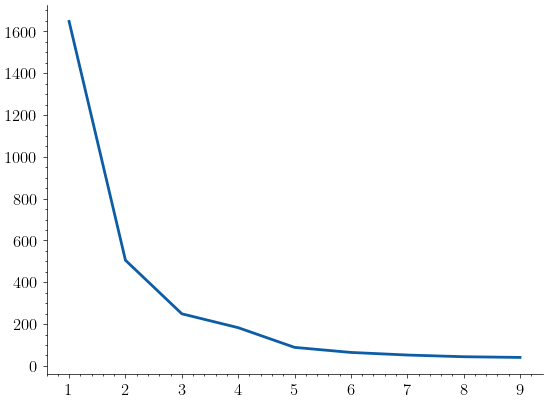

In [25]:
inertia =[] 
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,10),inertia)

In [26]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto")
kmeans.fit(X)

dataframe['kmeans'] = kmeans.labels_

for videoname, kmeans_label in zip(dataframe['video_name'], dataframe['kmeans']):
    for filename in os.listdir('C:\\Users\\leonardo\\Desktop\\icopevid results\\NCNN\\'):
        if videoname in filename:
            os.rename(os.path.join('C:\\Users\\leonardo\\Desktop\\icopevid results\\NCNN\\',filename),os.path.join(f'C:\\Users\\leonardo\\Desktop\\icopevid results\\NCNN\\{kmeans_label}',filename))
            break

In [27]:
stable = dataframe[dataframe['kmeans']==0]
irregular = dataframe[dataframe['kmeans']==2]
unstable = dataframe[dataframe['kmeans']==1]

for y in [stable, irregular, unstable]:
    print(f"{y['probs'].mean():.4f};{y['probs'].std():.4f}\n{y['entropy'].mean():.4f};{y['entropy'].std():.4f}\n{np.median(y['crossings']):.4f};{y['crossings'].std():.4f}\n".replace('.',','))

0,5253;0,3416
1,5387;0,7219
0,0000;0,7867

0,5350;0,1589
2,5613;0,5642
5,0000;1,2932

0,5755;0,0895
2,6566;0,2767
9,0000;2,7203



In [28]:
time = np.linspace(0,20,571)

In [29]:
def get_delta_t(signal, theta_1):

    time = np.linspace(0,20,len(signal))

    crossings = np.insert(np.where(np.diff(np.sign(signal-theta_1)))[0], 0, 0)
    crossings = np.insert(crossings, len(crossings), len(signal)-1)

    delta_t_pain = []
    delta_t_nopain = []

    for i in range(len(crossings)-1):
        delta_t = time[crossings[i+1]] - time[crossings[i]]
        avg_prob_delta_t = signal[crossings[i]:crossings[i+1]].mean()

        if avg_prob_delta_t >= theta_1:
            delta_t_pain.append(delta_t)
        else:
            delta_t_nopain.append(delta_t)

    return delta_t_pain, delta_t_nopain


### Pain Signal 0

In [30]:
stable.describe()

probs    entropy  crossings     labels  kmeans
count  72.000000  72.000000  72.000000  72.000000    72.0
mean    0.525290   1.538712   0.527778   0.388889     0.0
std     0.341621   0.721923   0.786725   0.490919     0.0
min     0.014974   0.000000   0.000000   0.000000     0.0
25%     0.185902   0.988541   0.000000   0.000000     0.0
50%     0.658350   1.580276   0.000000   0.000000     0.0
75%     0.839457   2.043656   1.000000   1.000000     0.0
max     0.977924   2.985208   2.000000   1.000000     0.0

In [31]:
stable['labels'].value_counts()

labels
0    44
1    28
Name: count, dtype: int64

In [32]:
stable['preds'].value_counts()

preds
True     37
False    35
Name: count, dtype: int64

In [33]:
metrics = validation_metrics(stable['preds'], stable['probs'], stable['labels'])

for values in metrics.values():
    print(f"{values:.4f}".replace('.',","))

0,7083
0,6769
0,5946
0,7857
0,6591
0,7078


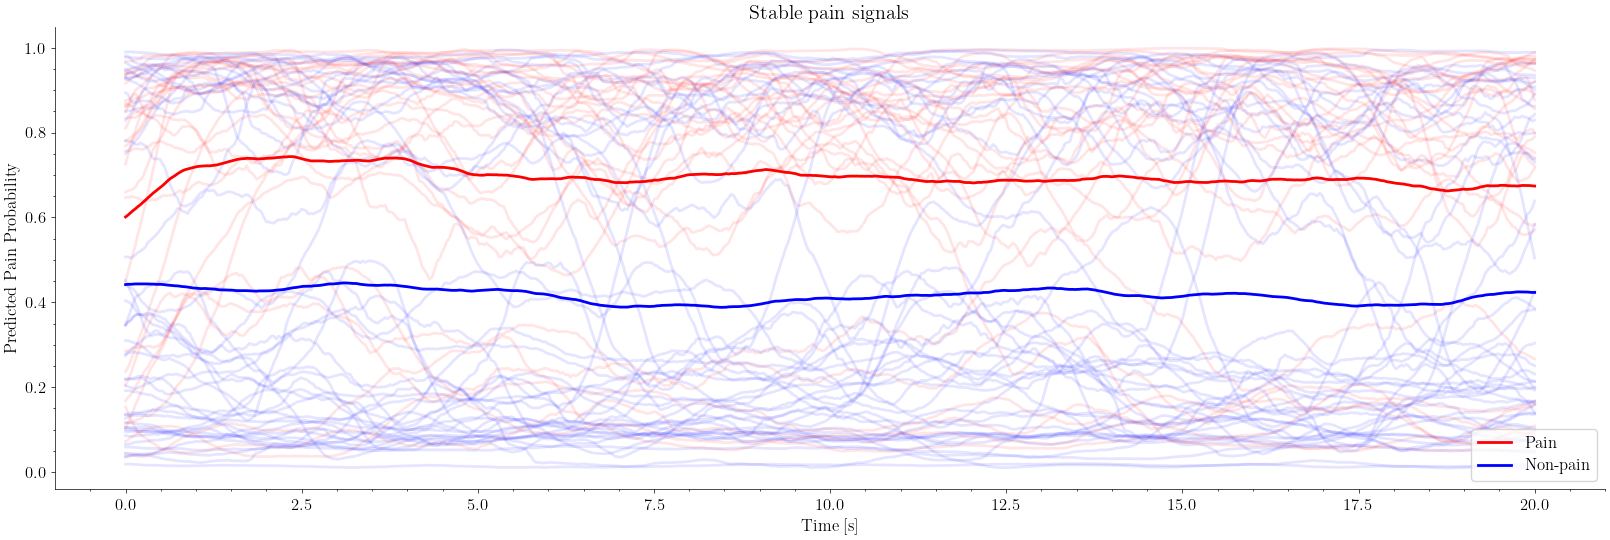

In [47]:
plt.figure(figsize=(20,6))

k_pain = np.array(stable[stable['labels']==1]['curves'])
k_nopain = np.array(stable[stable['labels']==0]['curves'])

mean_pain = np.mean(k_pain,axis=0)
mean_nopain = np.mean(k_nopain,axis=0)

for k in k_pain:
    plt.plot(time, k, 'r', alpha=0.1)

for k in k_nopain:
    plt.plot(time, k, 'b', alpha=0.1)

plt.plot(time, mean_pain, 'r', label='Pain')
plt.plot(time, mean_nopain, 'b', label='Non-pain')

plt.legend()
plt.title('Stable pain signals')
plt.xlabel('Time [s]')
plt.ylabel('Predicted Pain Probability')
plt.legend(loc="lower right")
plt.savefig(f"stable_signal_avg_{model}.pdf", dpi=150, bbox_inches='tight')

In [35]:
for prediction, k_signal in zip(["PAIN", "NO-PAIN"],[k_pain, k_nopain]):

    delta_t_pain_k = []
    delta_t_nopain_k = []

    total_pain_events = []
    total_nopain_events = []

    for signal in k_signal:
        delta_t_pain, delta_t_nopain = get_delta_t(signal, theta_1)
        
        delta_t_pain_k.extend(delta_t_pain)
        delta_t_nopain_k.extend(delta_t_nopain)

        total_pain_events.append(len(delta_t_pain))
        total_nopain_events.append(len(delta_t_nopain))


    delta_t_pain_k = np.array(delta_t_pain_k)
    delta_t_nopain_k = np.array(delta_t_nopain_k)

    total_pain_events = np.array(total_pain_events)
    total_nopain_events = np.array(total_nopain_events)


    print(f"Label {prediction}: Painful Event duration {delta_t_pain_k.mean():.4f} ± {delta_t_pain_k.std():.2f}, # Occurances: {total_pain_events.mean():.4f} ± {total_pain_events.std():.4f}")
    print(f"Label {prediction}: Non-Painful Event duration {delta_t_nopain_k.mean():.4f} ± {delta_t_nopain_k.std():.2f} # Occurances: {total_nopain_events.mean():.4f} ± {total_nopain_events.std():.4f}")
    print()

Label PAIN: Painful Event duration 15.3058 ± 6.57, # Occurances: 1.0000 ± 0.6547
Label PAIN: Non-Painful Event duration 8.7626 ± 8.63 # Occurances: 0.5357 ± 0.5658

Label NO-PAIN: Painful Event duration 11.2406 ± 7.53, # Occurances: 0.6364 ± 0.6773
Label NO-PAIN: Non-Painful Event duration 14.4939 ± 7.36 # Occurances: 0.8864 ± 0.4869



### Pain Signal 1

In [36]:
irregular.describe()

probs    entropy  crossings     labels  kmeans
count  33.000000  33.000000  33.000000  33.000000    33.0
mean    0.534975   2.561304   4.787879   0.393939     2.0
std     0.158876   0.564180   1.293193   0.496198     0.0
min     0.253004   0.366120   3.000000   0.000000     2.0
25%     0.417145   2.394930   4.000000   0.000000     2.0
50%     0.553598   2.702283   5.000000   0.000000     2.0
75%     0.643396   2.948376   6.000000   1.000000     2.0
max     0.877143   3.121107   7.000000   1.000000     2.0

In [37]:
irregular['labels'].value_counts()

labels
0    20
1    13
Name: count, dtype: int64

In [38]:
irregular['preds'].value_counts()

preds
True     22
False    11
Name: count, dtype: int64

In [39]:
metrics = (validation_metrics(irregular['preds'], irregular['probs'], irregular['labels']))

for values in metrics.values():
    print(f"{values:.4f}".replace('.',","))

0,4848
0,5143
0,4091
0,6923
0,3500
0,5500


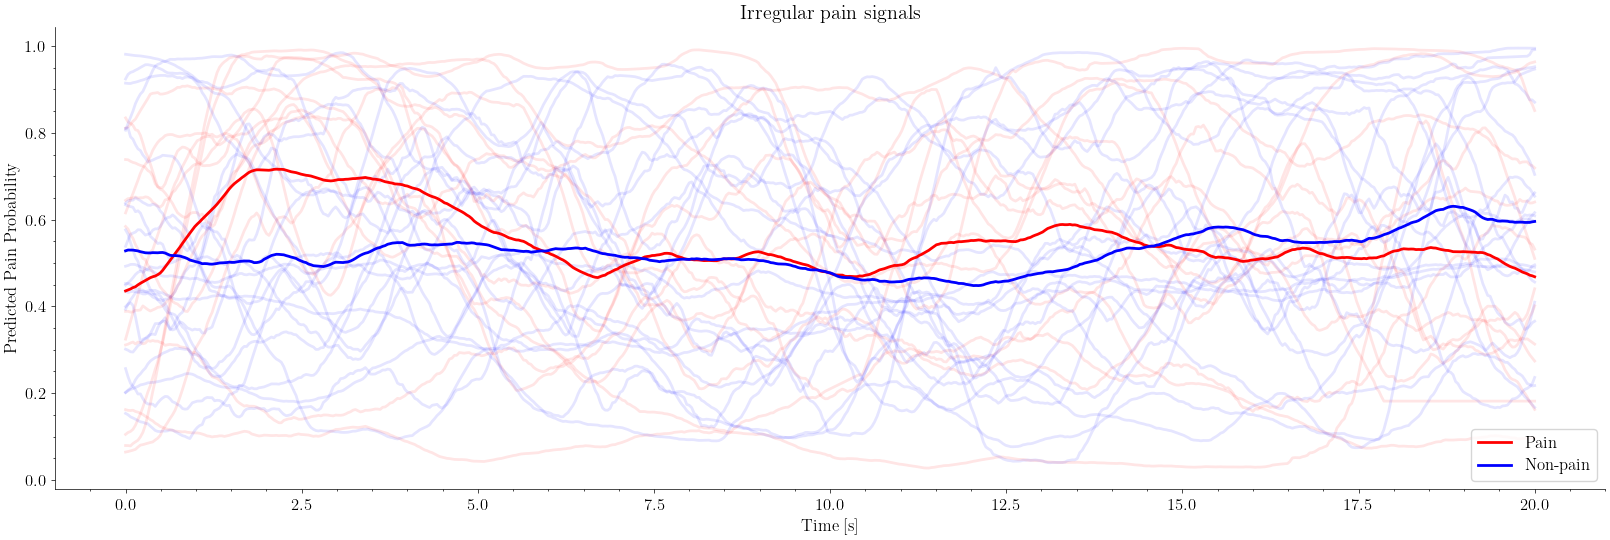

In [48]:
plt.figure(figsize=(20,6))

k_pain = np.array(irregular[irregular['labels']==1]['curves'])
k_nopain = np.array(irregular[irregular['labels']==0]['curves'])

mean_pain = np.mean(k_pain,axis=0)
mean_nopain = np.mean(k_nopain,axis=0)

for k in k_pain:
    plt.plot(time, k, 'r', alpha=0.1)

for k in k_nopain:
    plt.plot(time, k, 'b', alpha=0.1)

plt.plot(time, mean_pain, 'r', label='Pain')
plt.plot(time, mean_nopain, 'b', label='Non-pain')

plt.legend()
plt.title('Irregular pain signals')
plt.xlabel('Time [s]')
plt.ylabel('Predicted Pain Probability')
plt.legend(loc="lower right")
plt.savefig(f"irregular_signal_avg_{model}.pdf", dpi=150, bbox_inches='tight')

In [41]:
for prediction, k_signal in zip(["PAIN", "NO-PAIN"],[k_pain, k_nopain]):

    delta_t_pain_k = []
    delta_t_nopain_k = []

    total_pain_events = []
    total_nopain_events = []

    for signal in k_signal:
        delta_t_pain, delta_t_nopain = get_delta_t(signal, theta_1)
        
        delta_t_pain_k.extend(delta_t_pain)
        delta_t_nopain_k.extend(delta_t_nopain)

        total_pain_events.append(len(delta_t_pain))
        total_nopain_events.append(len(delta_t_nopain))


    delta_t_pain_k = np.array(delta_t_pain_k)
    delta_t_nopain_k = np.array(delta_t_nopain_k)

    total_pain_events = np.array(total_pain_events)
    total_nopain_events = np.array(total_nopain_events)


    print(f"Label {prediction}: Painful Event duration {delta_t_pain_k.mean():.4f} ± {delta_t_pain_k.std():.2f}, # Occurances: {total_pain_events.mean():.4f} ± {total_pain_events.std():.4f}")
    print(f"Label {prediction}: Non-Painful Event duration {delta_t_nopain_k.mean():.4f} ± {delta_t_nopain_k.std():.2f} # Occurances: {total_nopain_events.mean():.4f} ± {total_nopain_events.std():.4f}")
    print()

Label PAIN: Painful Event duration 4.0920 ± 3.61, # Occurances: 2.8462 ± 0.8635
Label PAIN: Non-Painful Event duration 2.8578 ± 3.42 # Occurances: 2.9231 ± 0.8285

Label NO-PAIN: Painful Event duration 3.2777 ± 3.66, # Occurances: 2.9000 ± 0.8888
Label NO-PAIN: Non-Painful Event duration 3.6189 ± 4.26 # Occurances: 2.9000 ± 0.7000



### Pain Signal 2

In [42]:
unstable.describe()

probs    entropy  crossings     labels  kmeans
count  15.000000  15.000000  15.000000  15.000000    15.0
mean    0.575483   2.656600  10.400000   0.533333     1.0
std     0.089458   0.276657   2.720294   0.516398     0.0
min     0.440474   2.264718   8.000000   0.000000     1.0
25%     0.507733   2.404500   8.500000   0.000000     1.0
50%     0.561013   2.673974   9.000000   1.000000     1.0
75%     0.627791   2.864911  11.500000   1.000000     1.0
max     0.759142   3.153566  16.000000   1.000000     1.0

In [43]:
unstable['labels'].value_counts()

labels
1    8
0    7
Name: count, dtype: int64

In [44]:
unstable['preds'].value_counts()

preds
True     11
False     4
Name: count, dtype: int64

In [45]:
metrics = (validation_metrics(unstable['preds'], unstable['probs'], unstable['labels']))

for values in metrics.values():
    print(f"{values:.4f}".replace('.',","))

0,5333
0,6316
0,5455
0,7500
0,2857
0,5714


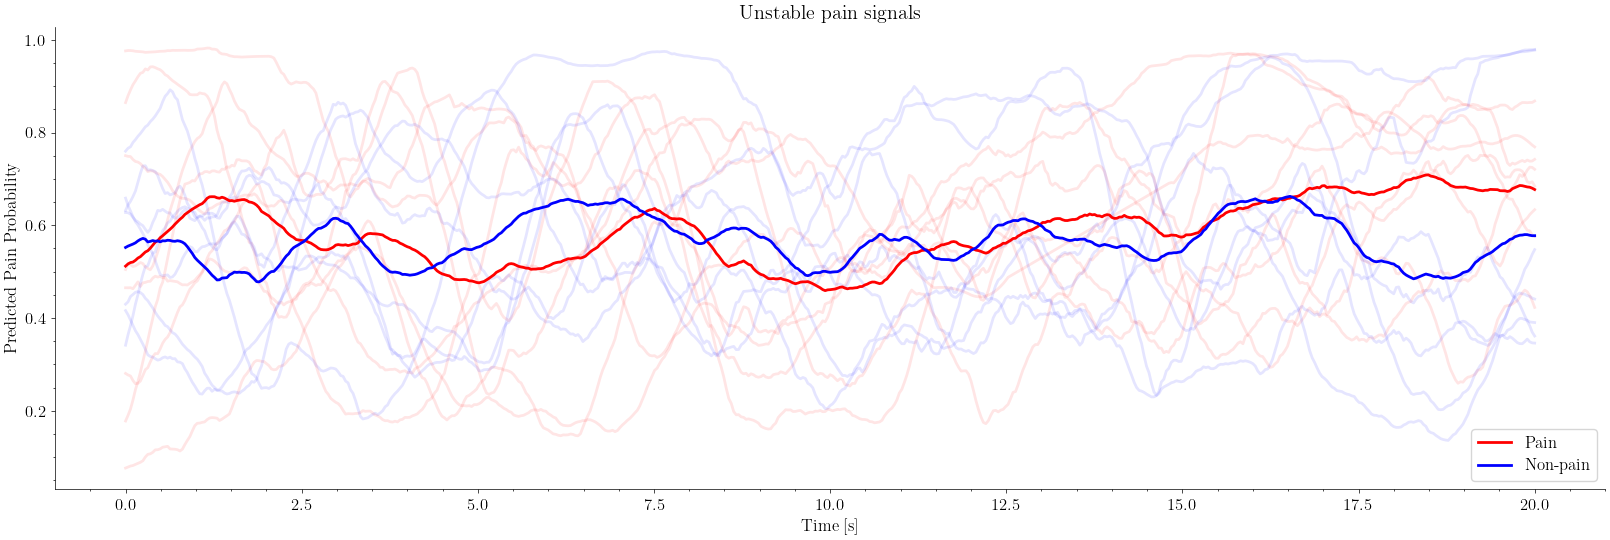

In [49]:
plt.figure(figsize=(20,6))

k_pain = np.array(unstable[unstable['labels']==1]['curves'])
k_nopain = np.array(unstable[unstable['labels']==0]['curves'])

mean_pain = np.mean(k_pain,axis=0)
mean_nopain = np.mean(k_nopain,axis=0)

for k in k_pain:
    plt.plot(time, k, 'r', alpha=0.1)

for k in k_nopain:
    plt.plot(time, k, 'b', alpha=0.1)

plt.plot(time, mean_pain, 'r', label='Pain')
plt.plot(time, mean_nopain, 'b', label='Non-pain')

plt.legend()
plt.title('Unstable pain signals')
plt.xlabel('Time [s]')
plt.ylabel('Predicted Pain Probability')
plt.legend(loc="lower right")
plt.savefig(f"unstable_signal_avg_{model}.pdf", dpi=150, bbox_inches='tight')

In [41]:
for prediction, k_signal in zip(["PAIN", "NO-PAIN"],[k_pain, k_nopain]):

    delta_t_pain_k = []
    delta_t_nopain_k = []

    total_pain_events = []
    total_nopain_events = []

    for signal in k_signal:
        delta_t_pain, delta_t_nopain = get_delta_t(signal, theta_1)
        
        delta_t_pain_k.extend(delta_t_pain)
        delta_t_nopain_k.extend(delta_t_nopain)

        total_pain_events.append(len(delta_t_pain))
        total_nopain_events.append(len(delta_t_nopain))


    delta_t_pain_k = np.array(delta_t_pain_k)
    delta_t_nopain_k = np.array(delta_t_nopain_k)

    total_pain_events = np.array(total_pain_events)
    total_nopain_events = np.array(total_nopain_events)


    print(f"Label {prediction}: Painful Event duration {delta_t_pain_k.mean():.4f} ± {delta_t_pain_k.std():.2f}, # Occurances: {total_pain_events.mean():.4f} ± {total_pain_events.std():.4f}")
    print(f"Label {prediction}: Non-Painful Event duration {delta_t_nopain_k.mean():.4f} ± {delta_t_nopain_k.std():.2f} # Occurances: {total_nopain_events.mean():.4f} ± {total_nopain_events.std():.4f}")
    print()

Label PAIN: Painful Event duration 2.9641 ± 2.18, # Occurances: 3.8333 ± 0.6872
Label PAIN: Non-Painful Event duration 2.2532 ± 2.08 # Occurances: 3.8333 ± 0.3727

Label NO-PAIN: Painful Event duration 3.4163 ± 3.26, # Occurances: 3.6667 ± 0.4714
Label NO-PAIN: Non-Painful Event duration 1.9783 ± 1.72 # Occurances: 3.7778 ± 0.6285



### CLuster Visualization

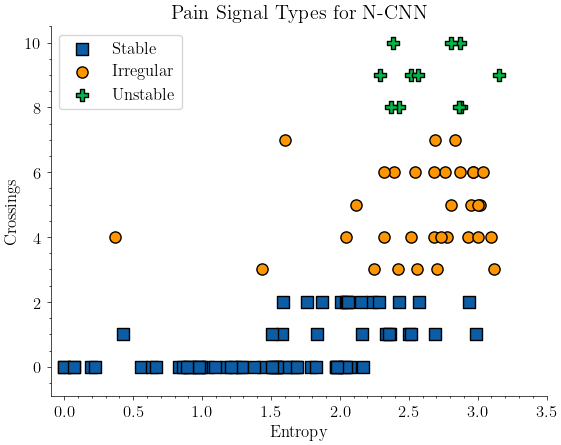

In [50]:
plt.scatter(stable['entropy'], stable['crossings'], marker='s', edgecolors='k', s=65, label='Stable')
plt.scatter(irregular['entropy'], irregular['crossings'], marker='o', edgecolors='k', s=65, label='Irregular')
plt.scatter(unstable['entropy'], unstable['crossings'], marker='P', edgecolors='k', s=65, label='Unstable')

plt.xlim([-0.1,3.5])
plt.ylim([-0.9,10.5])
plt.xlabel('Entropy')
plt.ylabel('Crossings')

#x1 = stable['entropy'].mean()+2*stable['entropy'].std()
#x2 = irregular['entropy'].mean()-2*irregular['entropy'].std()
#x = np.abs(x1-x2)/2

#y1 = irregular['crossings'].mean()+2*irregular['crossings'].std()
#y2 = unstable['crossings'].mean()-2*unstable['crossings'].std()
#y = np.abs(y1-y2)/2

vline = 1.25 if "VGG" in model else 1.75
hline = irregular['crossings'].max()+1

#plt.vlines(vline , ymax=10, ymin=-0.5, color='#8c8c8c', linestyles='--', linewidth=1.2)
#plt.hlines(hline, xmax=3.4, xmin=0, color='#8c8c8c', linestyles='--', linewidth=1.2)

plt.legend()

model_name = "VGG-Face" if "VGG" in model else "N-CNN"
plt.title(f'Pain Signal Types for {model_name}')

plt.savefig(f"plot_entropy_crossings_{model}.pdf", dpi=150, bbox_inches='tight')

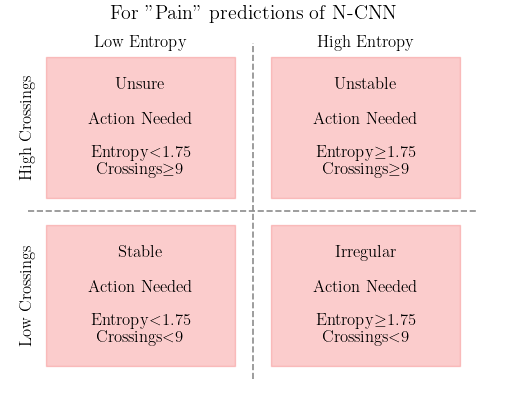

In [60]:
plt.axis('off')

plt.vlines(0.5 , ymax=1, ymin=0, color='#8c8c8c', linestyles='--', linewidth=1.2)
plt.hlines(0.5, xmax=1, xmin=0, color='#8c8c8c', linestyles='--', linewidth=1.2)

plt.text(0.75, 1, 'High Entropy', horizontalalignment='center', verticalalignment='center', weight='bold')
plt.text(0.25, 1, 'Low Entropy', horizontalalignment='center', verticalalignment='center')

plt.text(0, 0.75, 'High Crossings', horizontalalignment='center', verticalalignment='center', rotation=90)
plt.text(0, 0.25, 'Low Crossings', horizontalalignment='center', verticalalignment='center', rotation=90)

plt.text(0.75, 0.75, f"Unstable\n\nAction Needed\n\n Entropy$\ge${vline:.2f}\nCrossings$\ge${hline:.0f}", horizontalalignment='center', verticalalignment='center')
plt.text(0.75, 0.25, f"Irregular\n\nAction Needed\n\n Entropy$\ge${vline:.2f}\nCrossings$<${hline:.0f}", horizontalalignment='center', verticalalignment='center')
plt.text(0.25, 0.75, f"Unsure\n\nAction Needed\n\n Entropy$<${vline:.2f}\nCrossings$\ge${hline:.0f}", horizontalalignment='center', verticalalignment='center')
plt.text(0.25, 0.25, f"Stable\n\nAction Needed\n\n Entropy$<${vline:.2f}\nCrossings$<${hline:.0f}", horizontalalignment='center', verticalalignment='center')

plt.fill_between([0.04, 0.46], 0.04, 0.46, color='#f25757', alpha=0.3)
plt.fill_between([0.04, 0.46], 0.54, 0.96 , color='#f25757', alpha=0.3)
plt.fill_between([0.54, 0.96], 0.04, 0.46 , color='#f25757', alpha=0.3)
plt.fill_between([0.54, 0.96], 0.54, 0.96 , color='#f25757', alpha=0.3)


plt.title(f'For "Pain" predictions of {model_name}')

plt.savefig(f"pain_quadrant_{model}.png", dpi=150, bbox_inches='tight')

In [ ]:
plt.axis('off')

plt.vlines(0.5 , ymax=1, ymin=0, color='#8c8c8c', linestyles='--', linewidth=1.2)
plt.hlines(0.5, xmax=1, xmin=0, color='#8c8c8c', linestyles='--', linewidth=1.2)

plt.text(0.75, 1, 'High Entropy', horizontalalignment='center', verticalalignment='center', weight='bold')
plt.text(0.25, 1, 'Low Entropy', horizontalalignment='center', verticalalignment='center')

plt.text(0, 0.75, 'High Crossings', horizontalalignment='center', verticalalignment='center', rotation=90)
plt.text(0, 0.25, 'Low Crossings', horizontalalignment='center', verticalalignment='center', rotation=90)

plt.text(0.75, 0.75, f"Unstable\n\nAction Needed\n\n Entropy$\ge${vline:.2f}\nCrossings$\ge${hline:.0f}", horizontalalignment='center', verticalalignment='center')
plt.text(0.75, 0.25, f"Irregular\n\nAction Not Needed\n\n Entropy$\ge${vline:.2f}\nCrossings$<${hline:.0f}", horizontalalignment='center', verticalalignment='center')
plt.text(0.25, 0.75, f"Unsure\n\nAction Needed\n\n Entropy$<${vline:.2f}\nCrossings$\ge${hline:.0f}", horizontalalignment='center', verticalalignment='center')
plt.text(0.25, 0.25, f"Stable\n\nAction Not Needed\n\n Entropy$<${vline:.2f}\nCrossings$<${hline:.0f}", horizontalalignment='center', verticalalignment='center')

plt.fill_between([0.04, 0.46], 0.04, 0.46, color='#57F257', alpha=0.3)
plt.fill_between([0.04, 0.46], 0.54, 0.96 , color='#f25757', alpha=0.3)
plt.fill_between([0.54, 0.96], 0.04, 0.46 , color='#57F257', alpha=0.3)
plt.fill_between([0.54, 0.96], 0.54, 0.96 , color='#f25757', alpha=0.3)

plt.title(f'For "No-Pain" predictions of {model_name}')

plt.savefig(f"nopain_quadrant_{model}.png", dpi=150, bbox_inches='tight')